# STEP 1: Preprocessing administrative data

This is the first step in the computation. Running this notebook requires you to contact Statistics Denmark for data on population per square. Moreover, you also need to generate the grid data. 

Throughout we use various packages for network and spatial data. Some packages are not included in the standard Anaconda installer. E.g. with running the following line (assuming you are using a new `anaconda` from spring 2020).

`conda install -c conda-forge geopandas python-louvain -y`

### Before you proceed

If you do not have data gridded data you should either contact Statistics Denmark or use dummy data (Step 0). Note that you can change the list of municipalities, `dummy_mun_codes`, as well as and change the `dummy_compute` variable in the [config file](sqr/core/config.py). 

# Packages

In [2]:
import os
import itertools

import numpy as np
import pandas as pd
import pyproj
import geopandas as gpd
import shapely
import fiona

from tqdm import tqdm
import networkx as nx

from sqr.core.shape import make_gdf_square_data, find_neighbor_shapes
from sqr.core.shape import label2coord, polygon_from_north_east, make_spatial_grid
from sqr.pre_assign import assign_cells_partition, merge_insufficient, pre_partition_area
from sqr.miscellaneous import read_parse_mun
from sqr.core.config import years, cell_label

%matplotlib inline 

# Preprocess data

Generate square net grid data for each municipality.

Before proceeding you need to either contact Statistics Denmark (DST) about getting access to square net data or generate dummy dummy (see step 0). 

Load kvadratnet with population data into HDF store: 'data/parsed/kvadrat_data.hdf'

In [7]:
os.makedirs('data/parsed/', exist_ok=True)

# file paths for count data by square net cells
persons_path = 'data/raw/ind_dummy.csv'
households_path = 'data/raw/hh_dummy.csv'

reparse_pop_data = False
if reparse_pop_data:

    pers_df = pd.read_csv(persons_path)
    pers_df.to_hdf('data/parsed/KN100m_pop.hdf', key = 'pers', mode='w')

    hh_df = pd.read_csv(households_path)
    hh_df.to_hdf('data/parsed/KN100m_pop.hdf', key = 'hh', mode='a')

# Assign square to municipality shapes

### Load data
Load square cell population data  (for persons AND households) to perform various calculations.

In [8]:
dfs = {}
zeros_joint = {}
for label in ('pers', 'hh'):

    df = pd.read_hdf('data/parsed/KN100m_pop.hdf', key=label).fillna(0)
    df['minimum'] = df[years].min(axis=1)
    df['mean'] = df[years].mean(axis=1)
    
    dfs[label] = df
    
    
# compute overlap cells and begin computation for finding
# years where cells have new construction   
joint_cells = np.intersect1d(dfs['pers'][cell_label], dfs['hh'][cell_label])    
for label in ('pers', 'hh'):    
    dfs[label] = dfs[label]\
                    .set_index(cell_label)\
                    .reindex(joint_cells)\
                    .fillna(0)
          
    zeros_joint[label] = \
        dfs[label]\
            .loc[:,years]\
            .pipe(lambda df: (df==0).values.reshape(df.shape[0],df.shape[1],1))

zeros_all = \
    pd.DataFrame(
        data= np.concatenate([zeros_joint['pers'],
                              zeros_joint['hh']],
                             axis=2)\
                .min(axis=2),
        index=joint_cells,
        columns=years)


zeros = zeros_all[zeros_all.max(1)]
zeros_t = zeros.T

inhabit = (zeros_t.shift(1).fillna(False) & (~zeros_t))
inhabit_single = (inhabit.sum(axis=0)==1) & (~zeros.iloc[:,-1])
inhabit_year = zeros_t\
                .loc[:,inhabit_single]\
                .idxmin()\
                .rename('inhabit_year')\
                .astype(int)

# merge into single dataframe
pop = pd.concat(dfs,axis=1)
pop.columns = ['_'.join(reversed(c)) for c in  pop.columns.tolist()]
pop = pop.join(inhabit_year).reset_index()

/var/folders/02/sx0gjqb54z16jm_hb9w7g81r0000gn/T/ipykernel_32818/2156931905.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  inhabit = (zeros_t.shift(1).fillna(False) & (~zeros_t))


Load square cell information and geometries

In [9]:
from sqr.core.shape import make_spatial_grid 

if not os.path.exists('data/parsed/sqr_info.geojson'):
    gdf_kommuner = read_parse_mun(compute_stats=False)

    # compute grid
    coords = \
        gdf_kommuner\
        .groupby('KOMNAVN')\
        .apply(make_spatial_gridl, include_groups=True)\
        .drop_duplicates()\
        .reset_index(drop=True)

    # centroid coordinate
    coords['e_cent'] = (coords.e.astype(int)*100+50).astype(np.int32)    
    coords['n_cent'] = (coords.n.astype(int)*100+50).astype(np.int32)

    p1 = pyproj.Proj(fiona.crs.from_epsg(25832))
    p2 = pyproj.Proj(fiona.crs.from_epsg(4326))    

    gps_coords = pyproj.transform(p1, p2, coords.e_cent.values, coords.n_cent.values)
    gps_coords = pd.DataFrame(np.array(gps_coords).T, columns = ['lon_cent','lat_cent'])

    coords.join(gps_coords).to_file('data/parsed/sqr_info.geojson', driver='GeoJSON')
    
all_gdf = gpd.read_file('data/parsed/sqr_info.geojson')    

/var/folders/02/sx0gjqb54z16jm_hb9w7g81r0000gn/T/ipykernel_32818/2244682200.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_spatial_grid)\
/var/folders/02/sx0gjqb54z16jm_hb9w7g81r0000gn/T/ipykernel_32818/2244682200.py:21: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  gps_coords = pyproj.transform(p1, p2, coords.e_cent.values, coords.n_cent.values)


Assign square cells to municipalities (municipalities after kommunalreformen 2007)

In [14]:
gdf_kommuner = read_parse_mun(compute_stats=False)

assignments = assign_cells_partition(gdf_kommuner, all_gdf)

assignment_dict = assignments\
                    .groupby('assignment')\
                    .apply(lambda g: g.index.tolist(), include_groups=True)\
                    .to_dict()

/var/folders/02/sx0gjqb54z16jm_hb9w7g81r0000gn/T/ipykernel_32818/2479715319.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.index.tolist())\


Store assignments

In [19]:
for idx in assignment_dict.keys():
    assignment_idxs = assignment_dict[idx]
    
    out_df = all_gdf\
            .loc[assignment_idxs]\
            .drop('geometry', axis=1)\
            .reset_index()\
            .rename(columns={'index':'square_idx'})
    
    out_df = out_df.merge(pop, 
                          right_on=cell_label,
                          left_on=cell_label, 
                          how='left')
    
    pd.DataFrame(out_df).to_hdf('data/parsed/sqr_mun.hdf', key='sqidx%i'% idx)    

check no cells is overlapping for ANY pair of municipality indices

In [20]:
errors = []

mun_adjacent = find_neighbor_shapes(gdf_kommuner)[['idx1', 'idx2']].values

for (i1,i2) in mun_adjacent:    
    if np.intersect1d(assignment_dict[i1], assignment_dict[i2]).size>0:
        errors+= [(i1,i2)]
        
print (errors)        

[]


# Partition municipality shapes into chunks

In [23]:
gdf_kommuner  = read_parse_mun()

select =  gdf_kommuner[(gdf_kommuner.to_assign) & (gdf_kommuner.cell_count>25000)]

for idx in tqdm(select.index.tolist()):
    
    origin_geom= gdf_kommuner.loc[idx].geometry
    mun_df = pd.read_hdf('data/parsed/sqr_mun.hdf', 'sqidx%i' % idx)
    mun_gdf = make_gdf_square_data(mun_df)
    pre_part = pre_partition_area(mun_gdf, origin_geom)
    
    pre_part_suff = merge_insufficient(pre_part)
    
    assignment = assign_cells_partition(pre_part, mun_gdf)

    mun_df = mun_df\
                .join(assignment)\
             
    for sub_idx, sub_df in mun_df.groupby('assignment'):
        out_key = 'sqidx%i_%i' % (idx, sub_idx)
        sub_df.to_hdf('data/parsed/sqr_mun_sub.hdf', key = out_key)

  0%|                                                                      | 0/1 [00:00<?, ?it/s]/var/folders/02/sx0gjqb54z16jm_hb9w7g81r0000gn/T/ipykernel_32818/1585725183.py:9: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  mun_gdf = make_gdf_square_data(mun_df)
100%|██████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.36s/it]


Sanity check plot subpartitions

/var/folders/02/sx0gjqb54z16jm_hb9w7g81r0000gn/T/ipykernel_32818/2994068269.py:7: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  mun_gdf = make_gdf_square_data(mun_df)
/var/folders/02/sx0gjqb54z16jm_hb9w7g81r0000gn/T/ipykernel_32818/2994068269.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.unary_union)\


<Axes: >

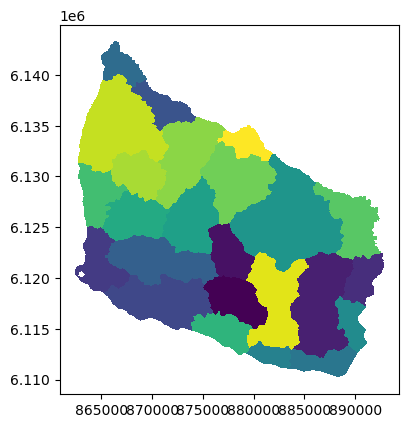

In [24]:
mun_code = '179' # select Bornholm

hdf = pd.HDFStore('data/parsed/sqr_mun_sub.hdf')
keys = [k for k in hdf.keys() if f'{mun_code}_' in k]    
hdf.close()
mun_df = pd.concat(pd.read_hdf('data/parsed/sqr_mun_sub.hdf', key = k) for k in keys)
mun_gdf = make_gdf_square_data(mun_df)

mun_gdf\
    .groupby('assignment')\
    .apply(lambda df: df.unary_union)\
    .pipe(lambda s: gpd.GeoDataFrame(s.index, geometry=gpd.GeoSeries(s)))\
    .plot(column='assignment')